In [1]:
import re
import unicodedata
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from env import user, password, host

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare

### 1. Spam Data

#### a. Load the spam data set.

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    '''
    This function cleans up text data.
    '''
    
    #lemmatize
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    #normalize
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
#look at how many messages are spam vs ham
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']

labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
#breaking up data into 3 separate pieces

#words that appear in legitimate text messages
ham_words = clean(' '.join(df[df.label == 'ham'].text))

#words that appear in spam text messages
spam_words = clean(' '.join(df[df.label == 'spam'].text))

#all of the words
all_words = clean(' '.join(df.text))

In [6]:
ham_words[:5]

['go', 'jurong', 'point', 'crazy', 'available']

In [7]:
spam_words[:5]

['free', 'entry', 'wkly', 'comp', 'win']

In [8]:
all_words[:15]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore']

In [9]:
#w/ list of words, we can transform it into a pandas Series,
#which can show how often each of the words occurs
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [10]:
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

In [11]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [12]:
all_freq.head()

call    600
im      462
get     397
ur      384
go      304
dtype: int64

In [13]:
#combine these 3 together to get one resulting df
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail(20)

,all,ham,spam
yunny,2,2,0
yuo,4,4,0
yuou,1,1,0
yup,43,43,0
yupz,1,1,0
ywhere,1,1,0
z,1,1,0
zac,1,1,0
zahers,1,1,0
zealand,1,1,0


In [14]:
#What are the most frequently occuring words?
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [15]:
#Are there any words that uniquely identify a spam or ham message?
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
didnt,79,79,0
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0


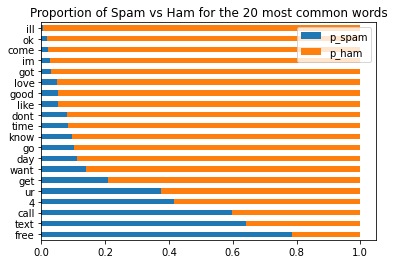

In [16]:
#visualize percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.show()

In [17]:
#get ratio
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


#### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

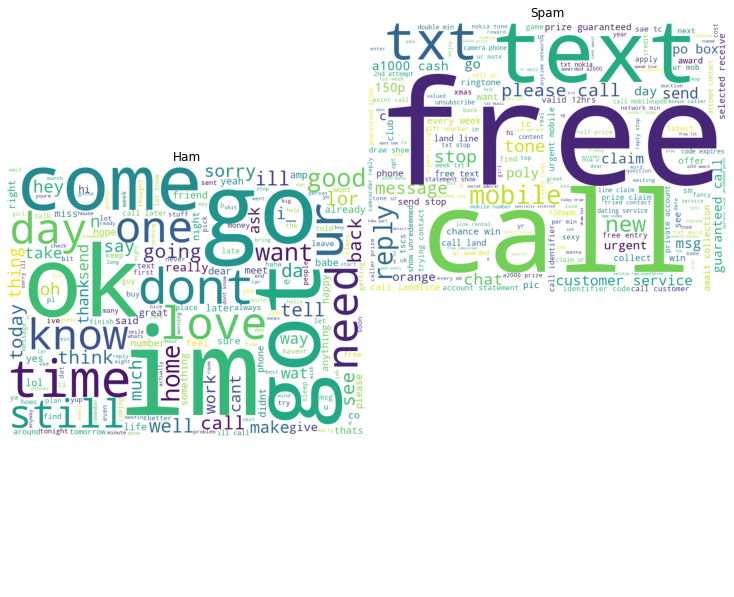

In [18]:
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(ham_cloud)
axs[1].imshow(spam_cloud)

axs[0].set_title('Ham')
axs[1].set_title('Spam')

for ax in axs: ax.axis('off')    


#### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [19]:
#spam bigrams
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

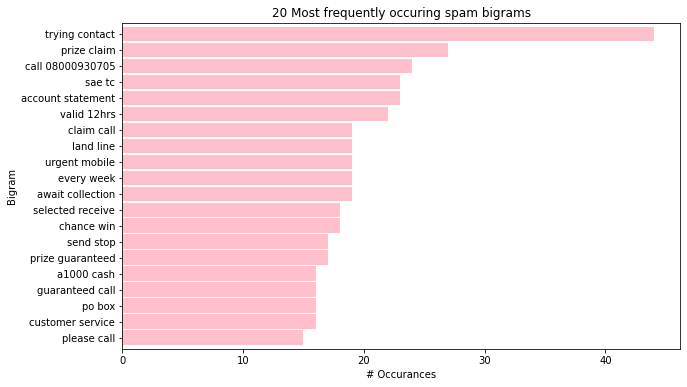

In [20]:
top_20_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [21]:
#ham bigrams
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

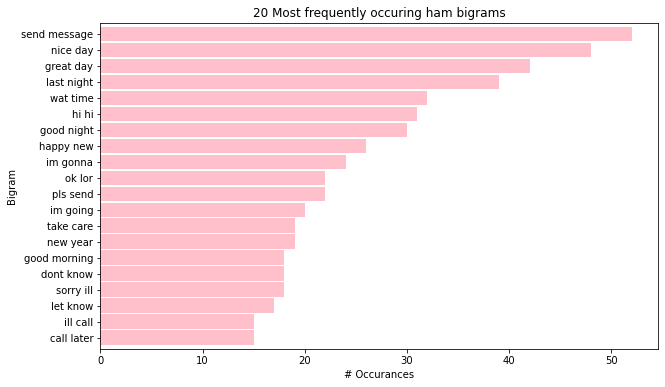

In [22]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

#### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [23]:
#spam trigrams
top_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))


top_spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(reply, call, 08000930705)             14
(land, line, claim)                    14
(2003, account, statement)             13
(private, 2003, account)               13
(camcorder, reply, call)               12
(show, 800, unredeemed)                12
(guaranteed, a1000, cash)              12
(tone, 4, ur)                          11
(every, week, txt)                     11
(please, call, customer)               11
(urgent, trying, contact)              11
(anytime, network, min)                11
(bonus, caller, prize)                 11
(customer, service, representative)    10
(a2000, bonus, caller)                 10
(speak, live, operator)                10
(cash, await, collection)              10
(ur, mob, every)                        9
dtype: int64

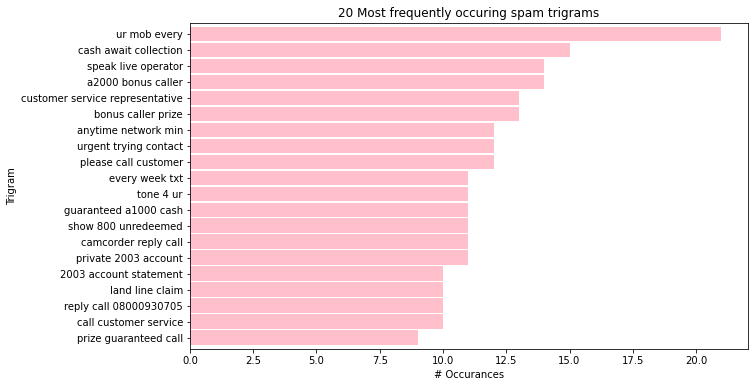

In [24]:
top_spam_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

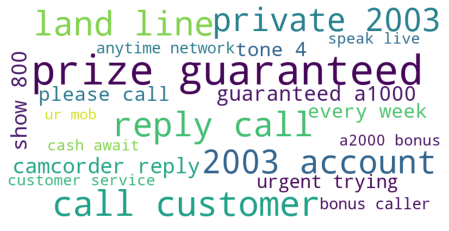

In [25]:
#use top spam trigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
#ham trigrams
top_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_ham_trigrams

(ill, call, later)            42
(sorry, ill, call)            38
(happy, new, year)            19
(pls, send, message)          13
(right, pls, send)            12
(pick, phone, right)          12
(phone, right, pls)           12
(cant, pick, phone)           12
(hi, hi, hi)                  11
(x, x, x)                      8
(good, morning, dear)          7
(pls, convey, birthday)        6
(convey, birthday, wish)       6
(call, later, meeting)         6
(kiss, across, sea)            6
(bday, wife, didnt)            5
(copy, friend, callertune)     5
(bedroom, minute, ok)          5
(wife, didnt, wish)            5
(mood, came, 5)                5
dtype: int64

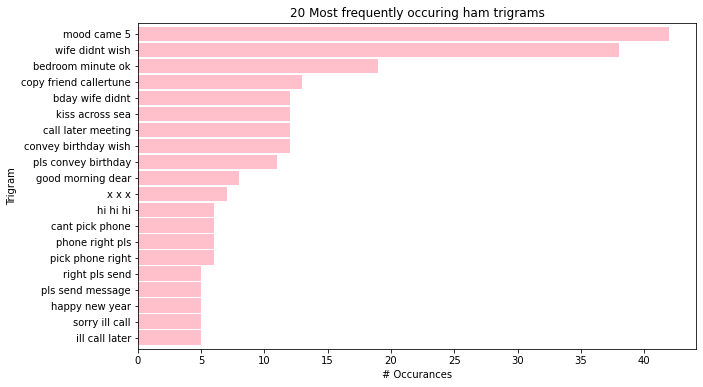

In [27]:
top_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

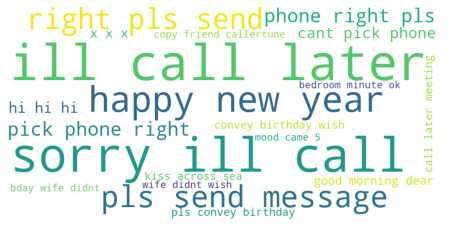

In [28]:
#use top ham trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [29]:
#acquiring blog articles
urls = ['https://codeup.com/codeups-data-science-career-accelerator-is-here/', 
        'https://codeup.com/data-science-myths/', 
        'https://codeup.com/data-science-vs-data-analytics-whats-the-difference/', 
        'https://codeup.com/10-tips-to-crush-it-at-the-sa-tech-job-fair/', 
        'https://codeup.com/competitor-bootcamps-are-closing-is-the-model-in-danger/']

codeup_df = pd.DataFrame(acquire.get_blog_articles(urls))

codeup_df

,title,content
0,Codeup’s Data Science Career Accelerator is Here!,The rumors are true! The time has arrived. Cod...
1,Data Science Myths,By Dimitri Antoniou and Maggie Giust\nData Sci...
2,Data Science VS Data Analytics: What’s The Dif...,"By Dimitri Antoniou\nA week ago, Codeup launch..."
3,10 Tips to Crush It at the SA Tech Job Fair,SA Tech Job Fair\nThe third bi-annual San Anto...
4,Competitor Bootcamps Are Closing. Is the Model...,Competitor Bootcamps Are Closing. Is the Model...


In [30]:
#applying clean function to get all normalized text in content column
all_words = clean(' '.join(codeup_df.content))

all_words[:10]

['rumor',
 'true',
 'time',
 'arrived',
 'codeup',
 'officially',
 'opened',
 'application',
 'new',
 'data']

In [31]:
#w/ list of words, transform into Series, & show how often each of the words occurs
all_freq = pd.Series(all_words).value_counts()
all_freq.head()

data        75
science     26
company     20
learning    20
job         14
dtype: int64

In [32]:
#Bigrams
top_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))


top_bigrams

(data, science)            26
(machine, learning)        14
(data, scientist)          13
(job, fair)                 9
(via, giphy)                5
(giphy, myth)               4
(intelligence, data)        4
(tech, job)                 4
(bootcamp, model)           4
(busted, via)               4
(san, antonio)              4
(big, education)            3
(seat, available)           3
(iron, yard)                3
(big, data)                 3
(sa, tech)                  3
(science, data)             3
(25, seat)                  3
(career, accelerator)       3
(programming, bootcamp)     3
dtype: int64

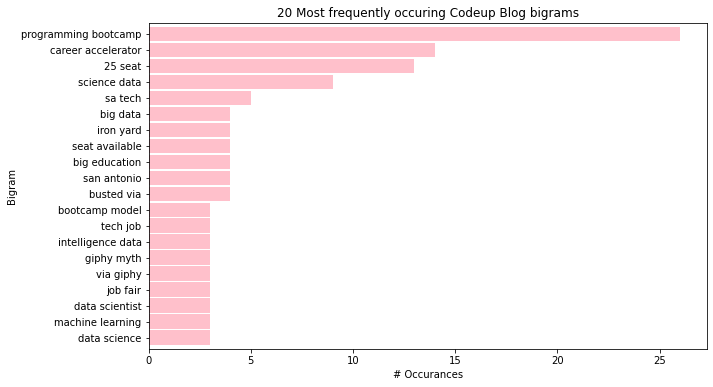

In [33]:
top_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Codeup Blog bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


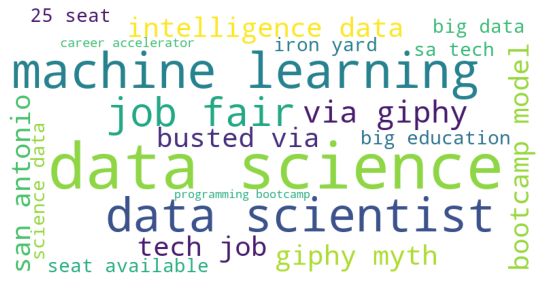

In [34]:
#use top bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
#trigrams
top_trigrams = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts()
                      .head(20))


top_trigrams

(tech, job, fair)                   4
(via, giphy, myth)                  4
(busted, via, giphy)                4
(sa, tech, job)                     3
(25, seat, available)               3
(data, science, data)               3
(goal, job, fair)                   2
(predict, future, event)            2
(science, career, accelerator)      2
(data, science, pipeline)           2
(still, question, reach)            2
(senior, data, scientist)           2
(supervised, machine, learning)     2
(company, using, term)              2
(question, reach, u)                2
(jack, guenther, pavilion)          2
(data, science, method)             2
(person, company, using)            2
(programming, bootcamp, model)      2
(actionable, intelligence, data)    2
dtype: int64

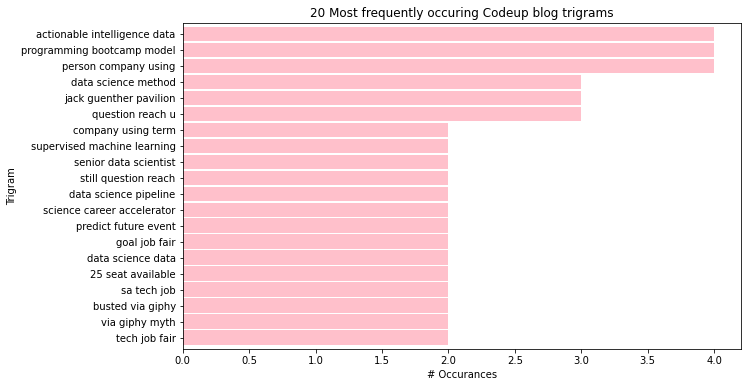

In [36]:
top_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Codeup blog trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

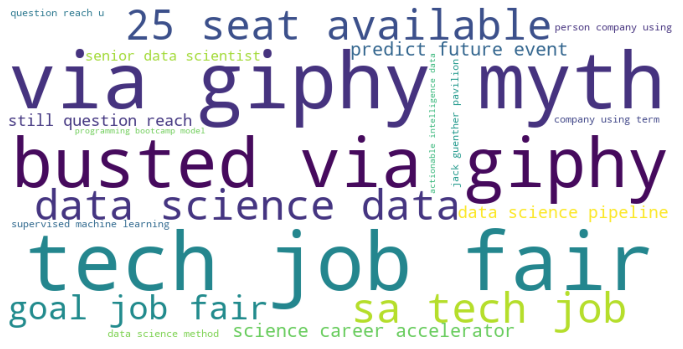

In [37]:
#use top trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [38]:
#acquiring news articles
categories = ['business', 'sports', 'technology', 'entertainment']

news_df = pd.DataFrame(acquire.get_news_articles(categories))

news_df

,title,content,category
0,"Godrej, PwC, Deloitte India give extra offs to...",Several companies in India have been offering ...,business
1,"Bill Gates' company Cascade transfers ₹13,300 ...","Bill Gates' Cascade Investment, a holding comp...",business
2,"Google adopts hybrid workweek, 20% staff to wo...",Google CEO Sundar Pichai informed employees th...,business
3,RIL may soon fly in Israeli experts to install...,Reliance Industries has sought permission to f...,business
4,Help nations prevent health crisis from becomi...,Finance Minister Nirmala Sitharaman on Wednesd...,business
...,...,...,...
95,Marathi actor Navnath Gaikwad passes away due ...,Marathi actor Navnath Gaikwad has passed away ...,entertainment
96,Satyajit Ray gave faces to rural poor & dignif...,"Filmmaker-actress Aparna Sen, while talking ab...",entertainment
97,It was our best option: Disha on multi-platfor...,Disha Patani recently spoke about her upcoming...,entertainment
98,Paras doesn't care much about his appearance o...,Speaking about working with Paras Chhabra in t...,entertainment


In [39]:
#look at how many words appear in each category
labels = pd.concat([news_df.category.value_counts(),
                    news_df.category.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']

labels

,n,percent
technology,25,0.25
sports,25,0.25
business,25,0.25
entertainment,25,0.25


In [40]:
#breaking up data into each category and applying clean function
#to get all normalized text in content column for each category

#words that appear in technology category
tech_words = clean(' '.join(news_df[news_df.category == 'technology'].content))

#words that appear in business category
bsns_words = clean(' '.join(news_df[news_df.category == 'business'].content))

#words that appear in sports category
sports_words = clean(' '.join(news_df[news_df.category == 'sports'].content))

#words that appear in entertainment category
ent_words = clean(' '.join(news_df[news_df.category == 'entertainment'].content))

#all of the words 
all_news_words = clean(' '.join(news_df.content))

In [41]:
#check how often each of the words occurs
tech_freq = pd.Series(tech_words).value_counts()
bsns_freq = pd.Series(bsns_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
ent_freq = pd.Series(ent_words).value_counts()
all_news_freq = pd.Series(all_news_words).value_counts()

print('Technology:')
print(tech_freq)
print('--------------------------')
print('Business:')
print(bsns_freq)
print('--------------------------')
print('Sports:')
print(sports_freq)
print('--------------------------')
print('Entertainment:')
print(ent_freq)
print('--------------------------')
print('All News:')
print(all_news_freq)
print('--------------------------')

Technology:
cryptocurrency    15
said              14
company           11
billion           10
dogecoin           8
                  ..
489                1
online             1
introduced         1
92000              1
390                1
Length: 604, dtype: int64
--------------------------
Business
said             18
india            14
company          13
crore             8
covid19           8
                 ..
autoambulance     1
largest           1
sought            1
flight            1
arcelormittal     1
Length: 635, dtype: int64
--------------------------
Sports
said         18
player       10
ipl          10
india         9
police        7
             ..
waiting       1
45            1
sustained     1
post          1
kroenkes      1
Length: 563, dtype: int64
--------------------------
Entertainment
said        21
actress     13
added       12
actor       10
covid19     10
            ..
seat         1
there        1
platform     1
multiple     1
costar       1
Length:

- 'said' appears in each category, going to add to additional stopwords and re-clean

In [42]:
ADDITIONAL_STOPWORDS = ['said']

#words that appear in technology category
tech_words = clean(' '.join(news_df[news_df.category == 'technology'].content))

#words that appear in business category
bsns_words = clean(' '.join(news_df[news_df.category == 'business'].content))

#words that appear in sports category
sports_words = clean(' '.join(news_df[news_df.category == 'sports'].content))

#words that appear in entertainment category
ent_words = clean(' '.join(news_df[news_df.category == 'entertainment'].content))

#all of the words 
all_news_words = clean(' '.join(news_df.content))

In [43]:
#check how often each of the words occurs
tech_freq = pd.Series(tech_words).value_counts()
bsns_freq = pd.Series(bsns_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
ent_freq = pd.Series(ent_words).value_counts()
all_news_freq = pd.Series(all_news_words).value_counts()

print('Technology:')
print(tech_freq)
print('--------------------------')
print('Business')
print(bsns_freq)
print('--------------------------')
print('Sports')
print(sports_freq)
print('--------------------------')
print('Entertainment')
print(ent_freq)
print('--------------------------')
print('All News')
print(all_news_freq)
print('--------------------------')

Technology:
cryptocurrency    15
company           11
billion           10
dogecoin           8
added              7
                  ..
489                1
online             1
introduced         1
92000              1
390                1
Length: 604, dtype: int64
--------------------------
Business
india            14
company          13
year              8
crore             8
covid19           8
                 ..
autoambulance     1
largest           1
sought            1
flight            1
arcelormittal     1
Length: 634, dtype: int64
--------------------------
Sports
player       10
ipl          10
india         9
australia     7
police        7
             ..
waiting       1
45            1
sustained     1
post          1
kroenkes      1
Length: 562, dtype: int64
--------------------------
Entertainment
actress     13
added       12
covid19     10
actor       10
film         8
            ..
seat         1
there        1
platform     1
multiple     1
costar       1
Length:

In [44]:
#variables for most common Bigrams for each category

tech_bigrams = (pd.Series(nltk.ngrams(tech_words, 2))
                      .value_counts()
                      .head(20))

bsns_bigrams = (pd.Series(nltk.ngrams(bsns_words, 2))
                      .value_counts()
                      .head(20))

sports_bigrams = (pd.Series(nltk.ngrams(sports_words, 2))
                      .value_counts()
                      .head(20))

ent_bigrams = (pd.Series(nltk.ngrams(ent_words, 2))
                      .value_counts()
                      .head(20))

all_bigrams = (pd.Series(nltk.ngrams(all_news_words, 2))
                      .value_counts()
                      .head(20))

In [45]:
#variables for most common Trigrams for each category

tech_trigrams = (pd.Series(nltk.ngrams(tech_words, 3))
                      .value_counts()
                      .head(20))

bsns_trigrams = (pd.Series(nltk.ngrams(bsns_words, 3))
                      .value_counts()
                      .head(20))

sports_trigrams = (pd.Series(nltk.ngrams(sports_words, 3))
                      .value_counts()
                      .head(20))

ent_trigrams = (pd.Series(nltk.ngrams(ent_words, 3))
                      .value_counts()
                      .head(20))

all_trigrams = (pd.Series(nltk.ngrams(all_news_words, 3))
                      .value_counts()
                      .head(20))

#### Technology Bigrams / Trigrams

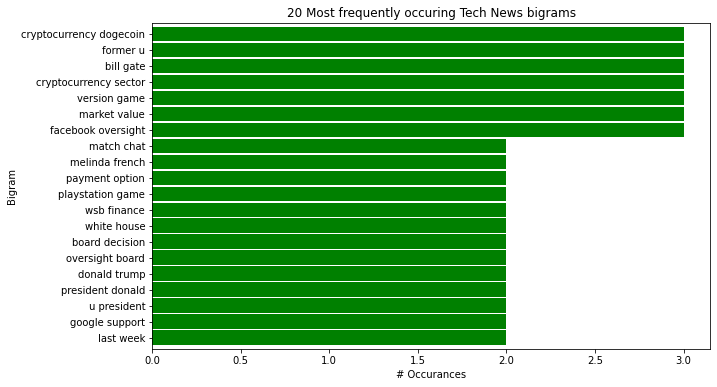

In [46]:
#bigrams
tech_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Tech News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = tech_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


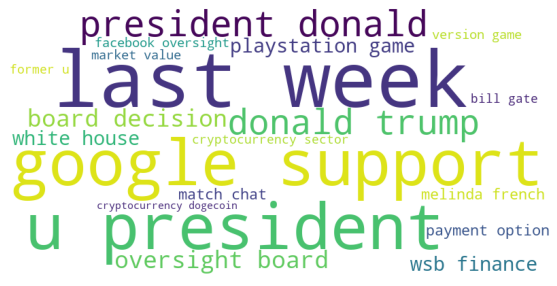

In [47]:
#use tech bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

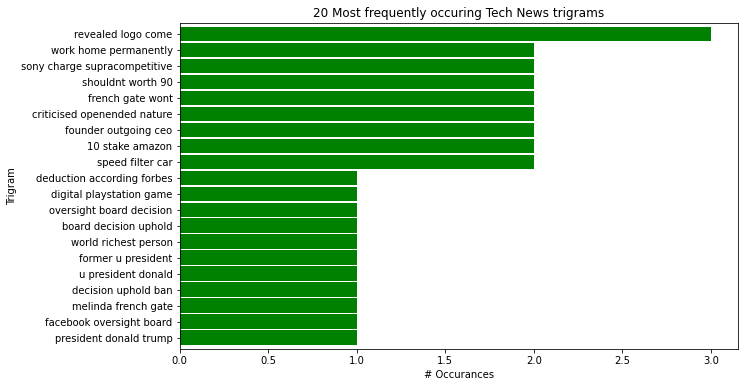

In [48]:
#trigrams
tech_trigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Tech News trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = tech_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

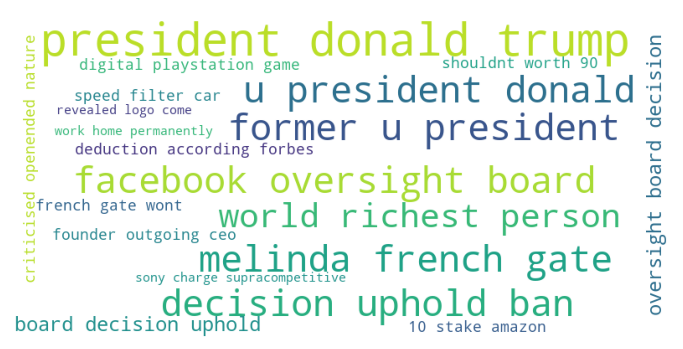

In [49]:
#use tech trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in tech_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

***
#### Business Bigrams / Trigrams

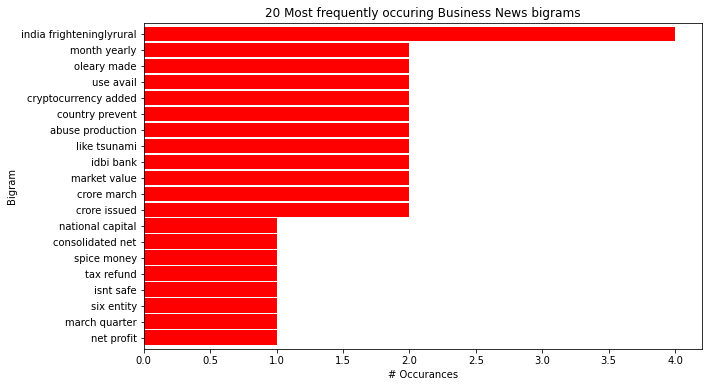

In [50]:
#bigrams
bsns_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Business News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = bsns_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


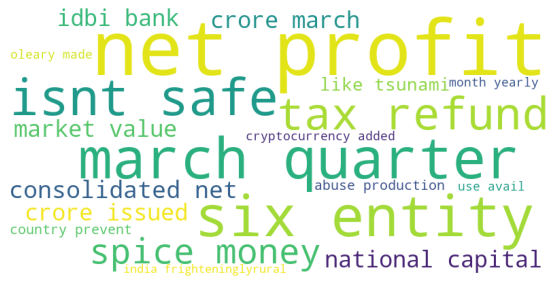

In [51]:
#use bsns bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in bsns_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

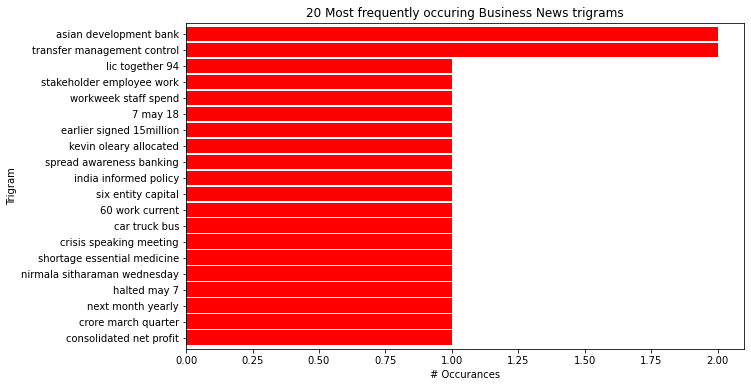

In [52]:
#trigrams
bsns_trigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Business News trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = bsns_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

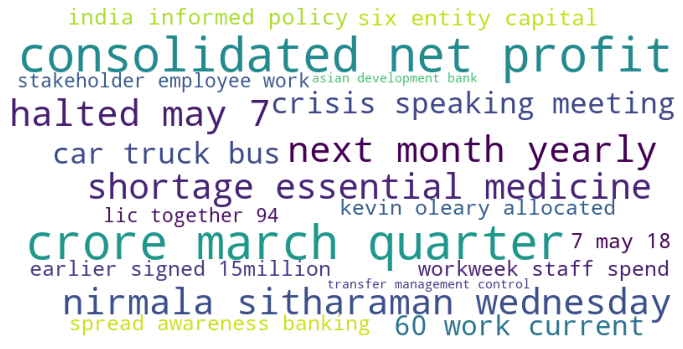

In [53]:
#use bsns trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in bsns_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Sports Bigrams / Trigrams

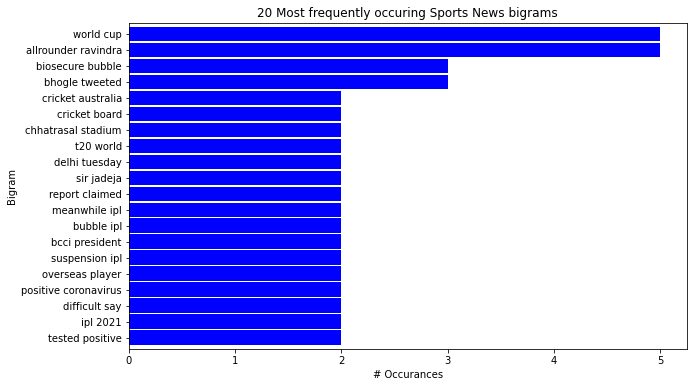

In [54]:
#bigrams
sports_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Sports News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = sports_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


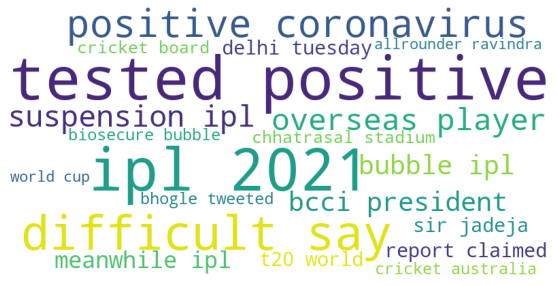

In [55]:
#use sports bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in sports_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

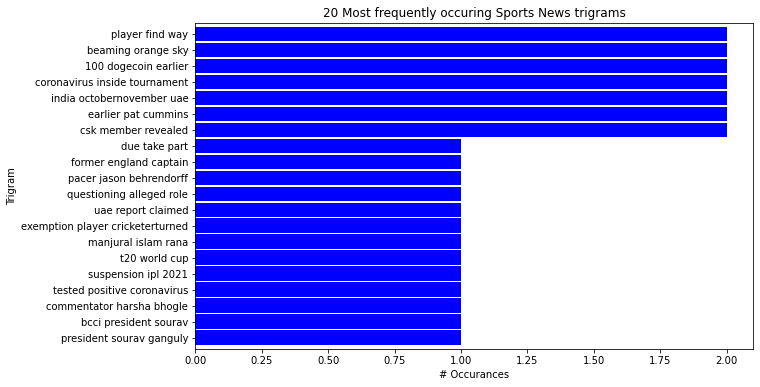

In [56]:
#trigrams
sports_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Sports News trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = sports_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

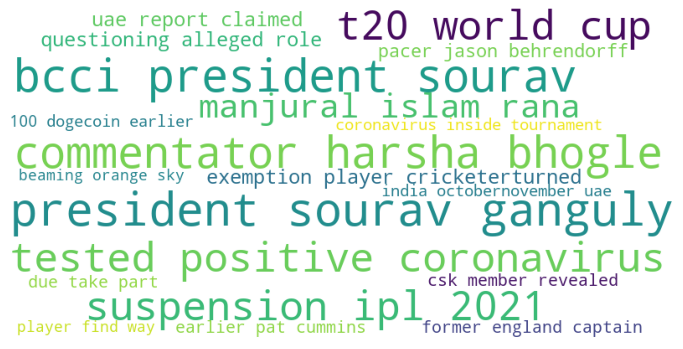

In [57]:
#use sports trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in sports_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Entertainment Bigrams / Trigrams

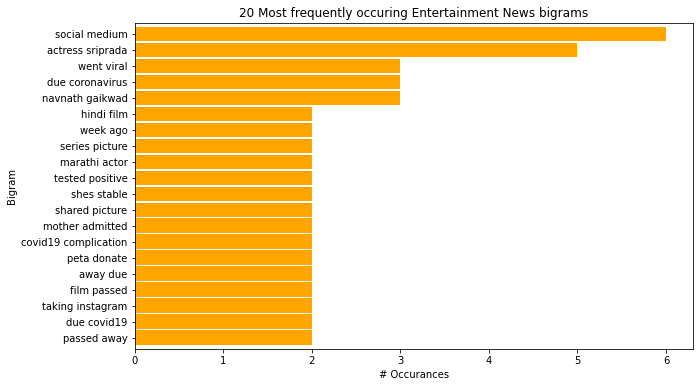

In [58]:
#bigrams
ent_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Entertainment News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = ent_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


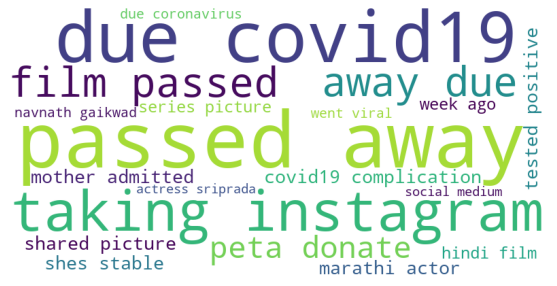

In [59]:
#use entertainment bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in ent_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

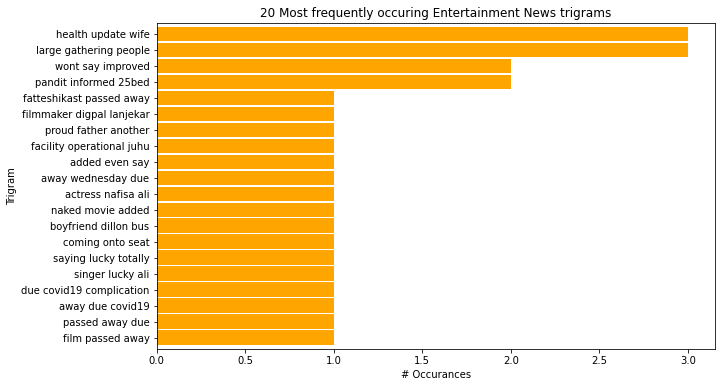

In [60]:
#trigrams
ent_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Entertainment News trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = ent_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

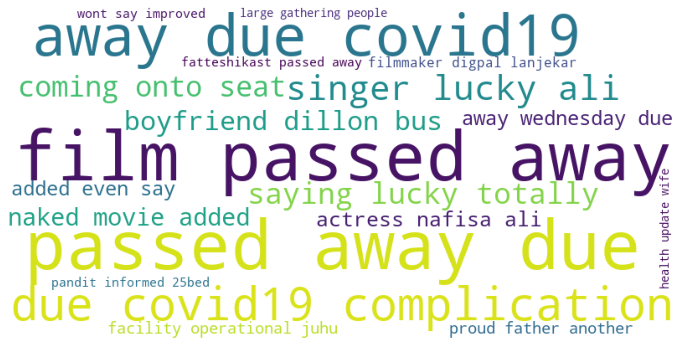

In [61]:
#use entertainment trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in ent_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### All News Bigrams / Trigrams

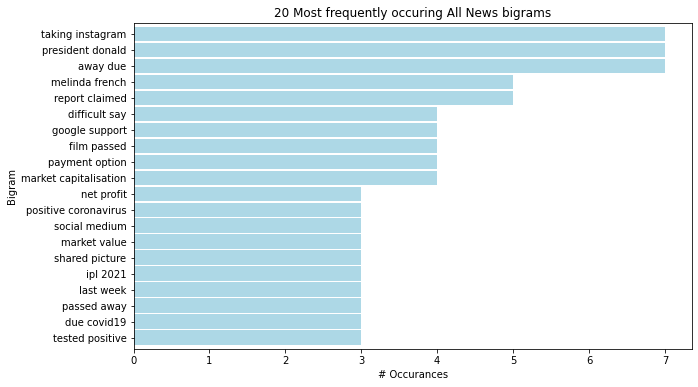

In [62]:
#bigrams
all_bigrams.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring All News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = all_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


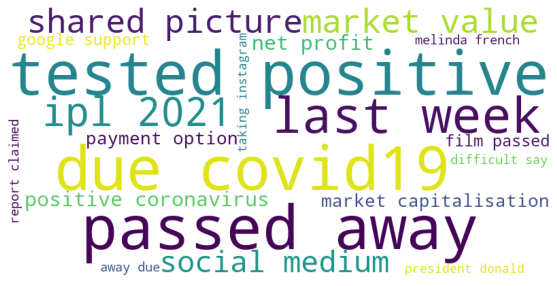

In [63]:
#use all bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in all_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

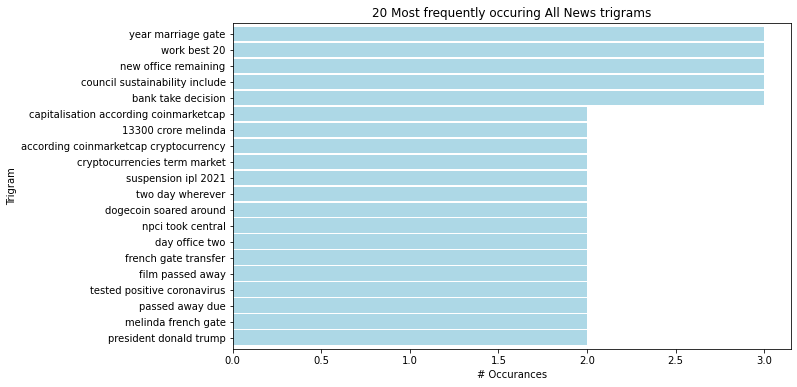

In [64]:
#trigrams
all_trigrams.sort_values().plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring All News trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = all_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

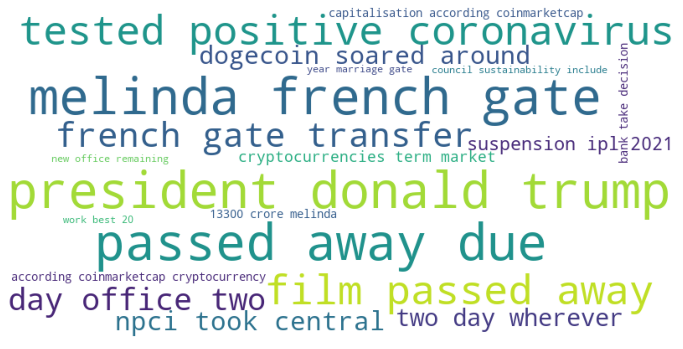

In [65]:
#use all trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in all_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()